In [14]:
%run -i billiard_defs.py
errors = 0

### Parameters
NP = np.arange(9,20) * sqrt_threads_per_block_max
modes = ['serial', 'parallel']
# modes = ['parallel']
run_time = {key:[] for key in modes}
pos = {key:[] for key in modes}

for num_part in NP:
    for mode in modes:
        start = timer()
        seed = 10
        rnd = np.random.RandomState(seed)

        dim = 2
        side = 10
        
        ## compute radius so that particles take up a fixed proportion of the volume of the box
        density = 0.1
        V_box = side**dim
        V_part_box = density * V_box / num_part  # volume of little box each particle must fit into
        radius = (V_part_box)**(1/dim) / 2
        mass = 4

        max_steps = 800
        max_records = 10
        try:
            rec_period = int(np.ceil(max_steps / max_records))
        except:
            rec_period = 1
        if (rec_period < 1) or (rec_period is np.inf):
            rec_period = 1

        wall = []
        for d in range(dim):
            for s in [-1,1]:
                v = np.zeros(dim, dtype=np_dtype)
                v[d] = s*side
                wall.append(FlatWall(base_point=v.copy(), normal=-v.copy()))

        part = Particles()

        # set any initial positions and velocities here

        part.initialize()
        part.KE_init = part.get_KE()
        part.check()
        part.record_state()

        if mode == 'parallel':
            %run -i gpu_defs.py
            #exec(open("gpu_defs.py").read())
            load_gpu(part)
            update_gpu(part)
            check_sync()
            part.check()

        def get_col_time(part):
            part.get_pw_col_time_cpu()
            if mode == 'parallel':
                get_pp_col_time_gpu(part)
            else:
                part.get_pp_col_time_cpu()
            part.dt = min([np.min(part.pp_dt), np.min(part.pw_dt)])
            return part.dt
        
        for step in range(max_steps):
            next_state(part)
            part.check()
            if mode == 'parallel':
                update_gpu(part)
                check_sync()

            if step % rec_period == 0:        
                print('num_part = {}, step = {}'.format(part.num,step))
                part.record_state()
                
        part.clean_up()
        elapsed = timer() - start
        print('Done!! #Particles = {}, Steps = {}, Sim Time = {:2f}, Elapsed Time = {:2f}'.format(part.num, len(part.t_hist)-1, part.t_hist[-1], elapsed))
        run_time[mode].append(elapsed)
        pos[mode].append(part.pos_hist.copy())
#     print(pos['serial'][-1] - pos['parallel'][-1])
    assert np.allclose(pos['serial'][-1], pos['parallel'][-1], rtol=0.01)

num_part = 288, step = 0
num_part = 288, step = 80
num_part = 288, step = 160
num_part = 288, step = 240
num_part = 288, step = 320
num_part = 288, step = 400
num_part = 288, step = 480
num_part = 288, step = 560
num_part = 288, step = 640
num_part = 288, step = 720
Done!! #Particles = 288, Steps = 10, Sim Time = 7.971440, Elapsed Time = 16.247188
load_gpu
num_part = 288, step = 0
num_part = 288, step = 80
num_part = 288, step = 160
num_part = 288, step = 240
num_part = 288, step = 320
num_part = 288, step = 400
num_part = 288, step = 480
num_part = 288, step = 560
num_part = 288, step = 640
num_part = 288, step = 720
Done!! #Particles = 288, Steps = 10, Sim Time = 7.971605, Elapsed Time = 8.165157
num_part = 320, step = 0
num_part = 320, step = 80
num_part = 320, step = 160
num_part = 320, step = 240
num_part = 320, step = 320
num_part = 320, step = 400
num_part = 320, step = 480
num_part = 320, step = 560
num_part = 320, step = 640
num_part = 320, step = 720
Done!! #Particles = 320, 

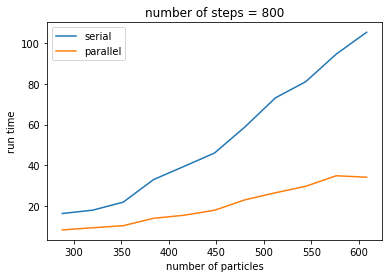

In [15]:
w = min([len(t) for k,t in run_time.items()])
for mode, time in run_time.items():
    plt.plot(NP[:w], run_time[mode][:w], label=mode)
plt.legend()
plt.xlabel('number of particles')
plt.ylabel('run time')
plt.title('number of steps = {}'.format(max_steps))
plt.show()

In [2]:
if dim != 2:
    raise Exception('only works in 2D')
    
num_steps = len(part.t_hist)

mesh = np.linspace(0,2*np.pi,100)
circle = [np.cos(mesh), np.sin(mesh)]
circle = radius * np.array(circle)
def draw(s=0):
    s %= num_steps
    fig, ax = plt.subplots(figsize=[8,8]);
    ax.plot([side,-side,-side,side,side], [side,side,-side,-side,side], color='black')    
    for p in range(part.num):
        ax.plot(part.pos_hist[:s+1,p,0], part.pos_hist[:s+1,p,1], color=part.clr[p])
        center = part.pos_hist[s,p]
        bdy = circle + center[:,np.newaxis]
        ax.plot(*bdy, color=part.clr[p])
    ax.set_aspect('equal')
    

l = widgets.Layout(width='150px')
step_text = widgets.BoundedIntText(min=0, max=num_steps-1, value=0, layout=l)
step_slider = widgets.IntSlider(min=0, max=num_steps-1, value=0, readout=False, continuous_update=False, layout=l)
play_button = widgets.Play(min=0, max=num_steps-1, step=1, interval=50, layout=l)

widgets.jslink((step_text, 'value'), (step_slider, 'value'))
widgets.jslink((step_text, 'value'), (play_button, 'value'))

img = widgets.interactive_output(draw, {'s':step_text})
display(widgets.HBox([widgets.VBox([step_text, step_slider, play_button]), img]))


HBox(children=(VBox(children=(BoundedIntText(value=0, layout=Layout(width='150px'), max=10), IntSlider(value=0, continuous_update=False, layout=Layout(width='150px'), max=10, readout=False), Play(value=0, interval=50, layout=Layout(width='150px'), max=10))), Output()))